In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 
n_features = 1 
path_train = 'data/train/'
path_test = 'data/test/'

C:\Program Files\Anaconda3\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


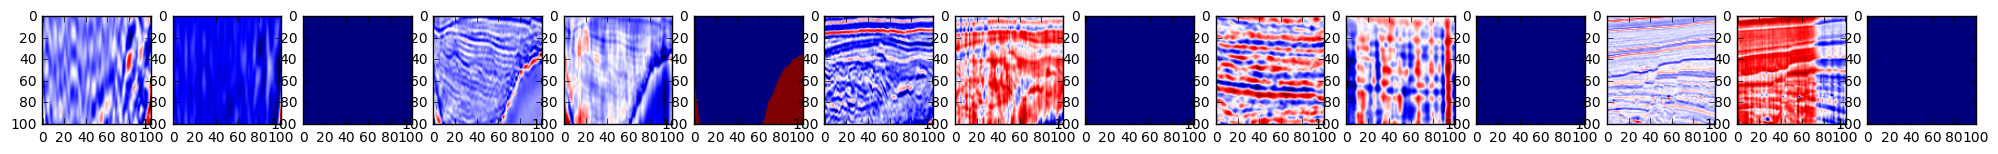

In [3]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(30,15))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('data/train/images/' + img_name + '.png', grayscale=True)
    img_mask = load_img('data/train/masks/' + img_name + '.png', grayscale=True)
    
    img = np.array(img)
    img_cumsum = (np.float32(img)-img.mean()).cumsum(axis=0)
    img_mask = np.array(img_mask)
    
    plt.subplot(1,3*(1+len(ids)),q*3-2)
    plt.imshow(img, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3-1)
    plt.imshow(img_cumsum, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3)
    plt.imshow(img_mask)
plt.show()

In [4]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train

    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


C:\Program Files\Anaconda3\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=2019)

C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


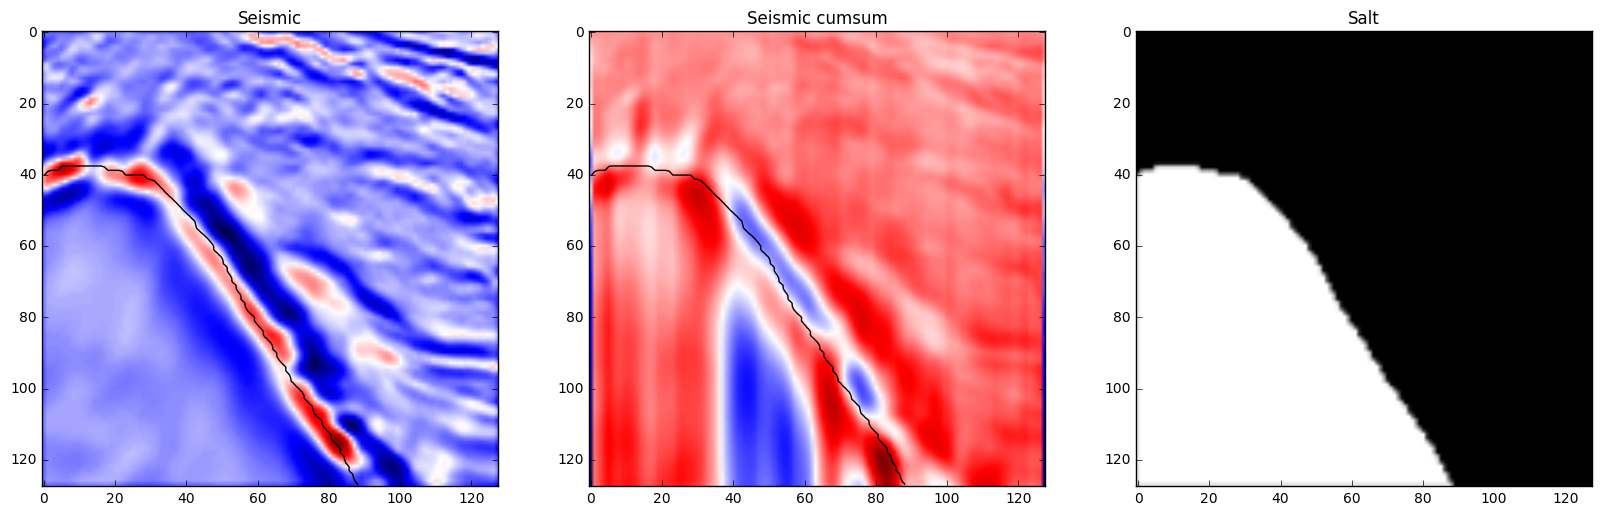

In [7]:
ix = random.randint(0, len(X_train))

has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(X_train[ix, ..., 1], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[1].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[1].set_title('Seismic cumsum')

ax[2].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[2].set_title('Salt');

In [8]:
image_generator = ImageDataGenerator(
                  featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.2, 
                  height_shift_range = 0.2, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')

mask_generator = ImageDataGenerator(
                  featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')

val_image_generator = ImageDataGenerator(
)
val_mask_generator = ImageDataGenerator(
)

train_img_gen = image_generator.flow(X_train , seed = 2018 , batch_size = 64)
train_mask_gen = mask_generator.flow(y_train , seed = 2018 , batch_size = 64)

val_img_gen = val_image_generator.flow(X_valid , seed = 2018 , batch_size = 64)
val_mask_gen = val_mask_generator.flow(y_valid , seed = 2018 , batch_size = 64)

C:\Program Files\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1437: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3600, 128, 128, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Program Files\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1437: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (400, 128, 128, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [9]:
train_gen = zip(train_img_gen , train_mask_gen)
val_gen = zip(val_img_gen , val_mask_gen)

In [10]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [11]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [12]:
def convlayer(inputs , filters , kernel_size , strides , activation = 'relu'):
    
    X = Conv2D(filters , kernel_size = (kernel_size , kernel_size) , strides = (strides , strides) , padding = 'same')(inputs)
    X = BatchNormalization()(X)
    X = Activation(activation)(X)
    
    if(activation != 'sigmoid'):
        sq = GlobalAveragePooling2D()(X)
        sq = Dense(int(filters / 4) , activation = 'relu')(sq)
        sq = Dense(filters , activation = 'sigmoid')(sq)
        sq = Reshape((1,1,filters))(sq)
        X = Multiply()([sq , X])
        
    return X

In [13]:
def resnet_block(inputs , filters , strides):
    
    identity = Conv2D(filters , kernel_size = (1 , 1) , strides = (strides , strides) , padding = 'same')(inputs)
    
    conv = Conv2D(filters , kernel_size = (3 , 3) , strides = (strides , strides) , padding = 'same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(filters , kernel_size = (3 , 3) , strides = (1 , 1), padding = 'same')(conv)
    conv = BatchNormalization()(conv)
    
    output = Add()([identity , conv])
    output = Activation('relu')(output)
    
    sq = GlobalAveragePooling2D()(output)
    sq = Dense(int(filters / 4) , activation = 'relu')(sq)
    sq = Dense(filters , activation = 'sigmoid')(sq)
    sq = Reshape((1,1,filters))(sq)
    ex = Multiply()([sq , output])
    
    return ex

In [14]:
def vgg_block(inputs, filters):
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    
    if (filters != 4):
        x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    return x

In [15]:
def upsample(inputs):
    
    X = UpSampling2D(size = (2,2))(inputs)
    
    return X

In [16]:
input_img = Input((im_height, im_width, im_chan), name='img')

inp = BatchNormalization()(input_img) 

res1 = resnet_block(inp, filters = 4, strides = 1)

res2 = resnet_block(res1, filters = 8, strides = 2)

res3 = resnet_block(res2, filters = 16, strides = 2)

res4 = resnet_block(res3, filters = 32, strides = 2)

res5 = resnet_block(res4, filters = 64, strides = 2)

vgg1 = vgg_block(inp, filters = 4)

vgg2 = vgg_block(vgg1, filters = 8)

vgg3 = vgg_block(vgg2, filters = 16)

vgg4 = vgg_block(vgg3, filters = 32)

vgg5 = vgg_block(vgg4, filters = 64)

mid = concatenate([res5, vgg5])

up1 = upsample(mid)
up1 = convlayer(up1 , filters = 32 , kernel_size = 3 , strides = 1)
up1 = convlayer(up1 , filters = 32 , kernel_size = 3 , strides = 1)
up1 = convlayer(up1 , filters = 32 , kernel_size = 3 , strides = 1)

up2 = upsample(up1)
up2 = convlayer(up2 , filters = 16 , kernel_size = 3 , strides = 1)
up2 = convlayer(up2 , filters = 16 , kernel_size = 3 , strides = 1)
up2 = convlayer(up2 , filters = 16 , kernel_size = 3 , strides = 1)

up3 = upsample(up2)
up3 = convlayer(up3 , filters = 8 , kernel_size = 3 , strides = 1)
up3 = convlayer(up3 , filters = 8 , kernel_size = 3 , strides = 1)
up3 = convlayer(up3 , filters = 8 , kernel_size = 3 , strides = 1)

up4 = upsample(up3)
up4 = convlayer(up4 , filters = 4 , kernel_size = 3 , strides = 1)
up4 = convlayer(up4 , filters = 4 , kernel_size = 3 , strides = 1)
up4 = convlayer(up4 , filters = 4 , kernel_size = 3 , strides = 1)

outputs = convlayer(up4 , filters = 1 , kernel_size = 3 , strides = 1 , activation = 'sigmoid')

model = Model(inputs=[input_img], outputs=[outputs])

model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss=create_weighted_binary_crossentropy(0.24, 0.74), 
              metrics=[mean_iou , 'accuracy']) 

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 2)  8           img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 4)  76          batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 4)  16          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation

In [17]:
callbacks = [
    EarlyStopping(monitor= 'val_mean_iou', patience=15, verbose=2, mode='max'),
    ReduceLROnPlateau(monitor= 'val_loss', factor=0.1, patience=10, verbose=2, min_lr=1e-6, mode='min'),
    ModelCheckpoint('tgs-res_vgg_segnet.h5', monitor='val_mean_iou', verbose=2, save_best_only=True , mode = 'max')
]

results = model.fit_generator(train_gen , steps_per_epoch = 300 , epochs = 300,
                              validation_data = val_gen , validation_steps = 7 ,
                              callbacks=callbacks , verbose = 2)

Epoch 1/300
 - 493s - loss: 0.1995 - mean_iou: 0.4796 - acc: 0.7380 - val_loss: 0.2168 - val_mean_iou: 0.5470 - val_acc: 0.8543

Epoch 00001: val_mean_iou improved from -inf to 0.54704, saving model to tgs-res_vgg_segnet.h5
Epoch 2/300
 - 471s - loss: 0.1535 - mean_iou: 0.5721 - acc: 0.7841 - val_loss: 0.1873 - val_mean_iou: 0.5885 - val_acc: 0.8890

Epoch 00002: val_mean_iou improved from 0.54704 to 0.58848, saving model to tgs-res_vgg_segnet.h5
Epoch 3/300
 - 471s - loss: 0.1429 - mean_iou: 0.5986 - acc: 0.7923 - val_loss: 0.1284 - val_mean_iou: 0.6078 - val_acc: 0.8848

Epoch 00003: val_mean_iou improved from 0.58848 to 0.60776, saving model to tgs-res_vgg_segnet.h5
Epoch 4/300
 - 470s - loss: 0.1306 - mean_iou: 0.6157 - acc: 0.8093 - val_loss: 0.1214 - val_mean_iou: 0.6225 - val_acc: 0.8228

Epoch 00004: val_mean_iou improved from 0.60776 to 0.62252, saving model to tgs-res_vgg_segnet.h5
Epoch 5/300
 - 471s - loss: 0.1272 - mean_iou: 0.6274 - acc: 0.8092 - val_loss: 0.1102 - val_me

In [18]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    
    img = load_img(path + '/images/' + id_, grayscale=True)
    x = img_to_array(img)
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    
    x_center_mean = x[border:-border, border:-border].mean()
    x_csum = (np.float32(x)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    X_test[n, ..., 0] = x.squeeze() / 255
    X_test[n, ..., 1] = x_csum.squeeze()

print('Done!')

Getting and resizing test images ... 


C:\Program Files\Anaconda3\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [19]:
model.load_weights('tgs-res_vgg_segnet.h5')

In [20]:
model.evaluate(X_valid, y_valid, verbose=1)

400/400 [==============================] - 5s 13ms/step


[0.087503840029239652, 0.74064286231994625, 0.91455795288085939]

In [21]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 118s 7ms/step


In [22]:
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [23]:
preds_test_upsampled[0].shape

(101, 101)

In [24]:
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Seismic cumsum')

    ax[2].imshow(y[ix].squeeze())
    ax[2].set_title('Salt')

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Pred');

C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


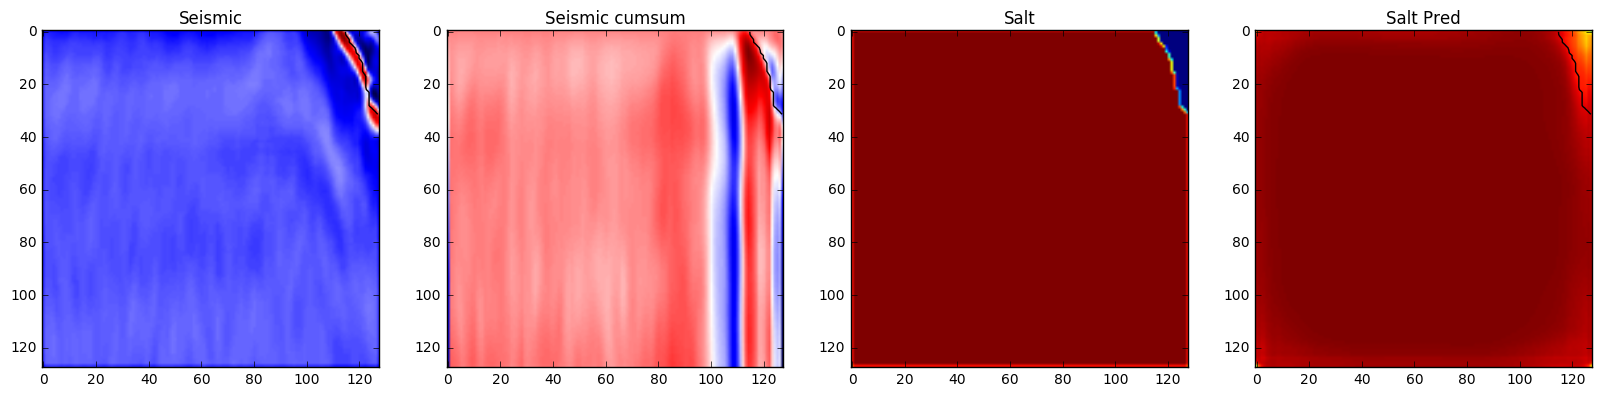

In [25]:
plot_sample(X_train, y_train, preds_train)

C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Program Files\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


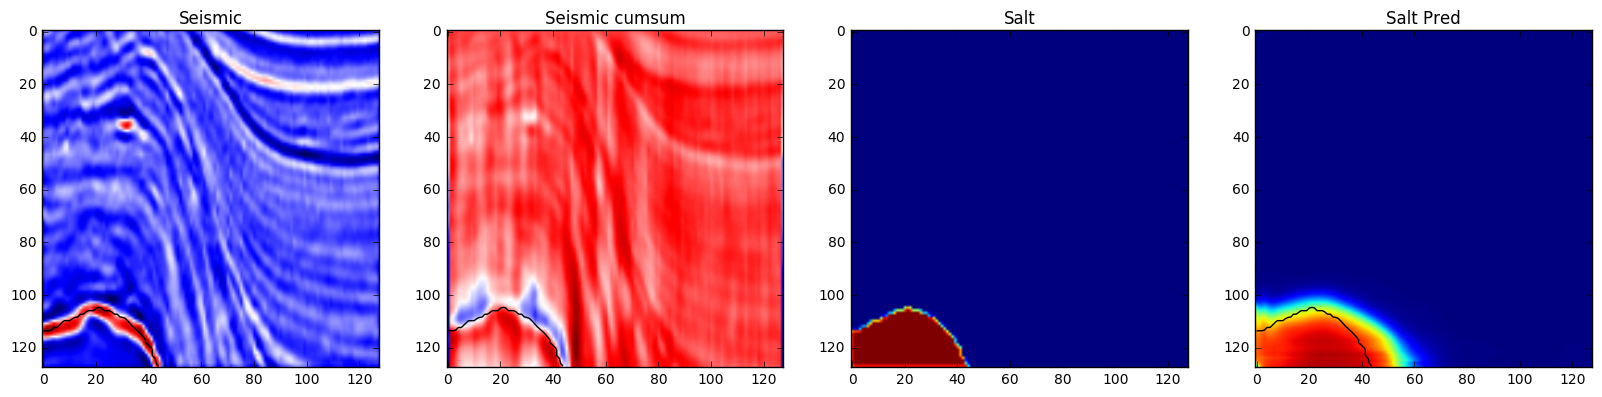

In [26]:
plot_sample(X_valid, y_valid, preds_val)

In [27]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [28]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(y_valid, np.int32(preds_val > t)) for t in tqdm_notebook(thres)]

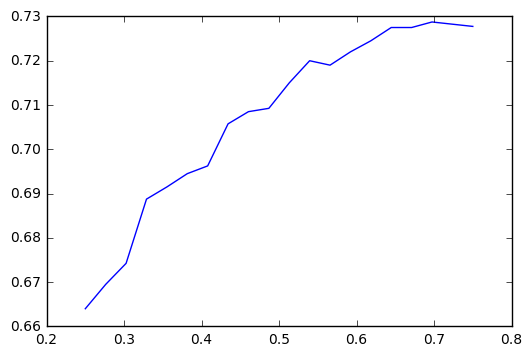

In [29]:
plt.plot(thres, thres_ioc);

In [30]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.69736842105263153, 0.72875000000000001)

In [31]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {id_[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [32]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('outputs.csv')